# __This is a notebook of a PyTorch brain tumor semantic segmentation with Unet++ (ResNet101 backbone)!__ 
# Project by __[Nikita Bezukhov](https://github.com/NikitaBezukhov)__!
### The data set is __[Brain MRI segmentation from Kaggle](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation)__.
### Was built in __[Google Colab](https://colab.research.google.com/)__ environment, so make any adjustments needed for it to work on your machine.

####
####
## __1. First lets install, import and define all necessary libraries/classes/functions that we will be using.__

In [ ]:
pip install barbar git+https://github.com/albumentations-team/albumentations segmentation_models_pytorch

In [35]:
import os
import segmentation_models_pytorch 
import logging
import torch
import gc
import re
import torch
import cv2
import random
import torchvision
from imageio import imread
from math import exp
import torch.nn as nn
from PIL import Image, ImageOps, ImageShow
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from sklearn.metrics import jaccard_score
import torch.nn.init as init
from torch.autograd import Variable
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms, datasets 
from shutil import copyfile, move
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from barbar import Bar
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print,best_score=None):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = best_score
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when monitored metric decrease.'''
        if self.verbose:
            self.trace_func(f'Monitored metric has improved ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'/content/drive/MyDrive/brainmodelunetpp.pt') 
        self.val_loss_min = val_loss

## __2. Data preparation.__
### Dataset consists of MRI brain scans and ground truth masks.
### We will unzip data, copy all scans and masks from different folders into 2 folders (masks, scans).

In [ ]:
!unzip /content/drive/MyDrive/brain_scans.zip -d /content

In [8]:
os.mkdir('/content/scans/')
os.mkdir('/content/masks/')

In [9]:
scans_dir = '/content/scans/'
masks_dir = '/content/masks/'

In [10]:
 folders = os.listdir('/content/kaggle_3m/')

In [11]:
for folder in folders:
    next_folder = '/content/kaggle_3m/'+folder
    try:
        for image in os.listdir(next_folder):
            if 'mask' in image:
                copyfile(os.path.join(next_folder, image), os.path.join(masks_dir, image)) 
            else:
                copyfile(os.path.join(next_folder, image), os.path.join(scans_dir, image))   
    except:
        pass

In [ ]:
print(len(os.listdir(scans_dir)))
print(len(os.listdir(masks_dir)))

### Now we will make lists of scan and mask names, sort them so masks and scans would be in the same order in lists, shuffle together and then split into train/val sets 85/15%.

In [13]:
scan_list = os.listdir(scans_dir)
mask_list = os.listdir(masks_dir)

In [14]:
scan_list.sort(key=lambda f: int(re.sub('\D', '', f)))
mask_list.sort(key=lambda f: int(re.sub('\D', '', f)))

In [15]:
c = list(zip(scan_list, mask_list))

random.shuffle(c)

scan_list, mask_list = zip(*c)

In [ ]:
scan_list[0:11]

In [ ]:
mask_list[0:11]

In [18]:
ind = len(scan_list)

In [19]:
train_scan = scan_list[:int(ind*0.85)]
train_mask = mask_list[:int(ind*0.85)]
val_scan = scan_list[int(ind*0.85):]
val_mask = mask_list[int(ind*0.85):]

In [ ]:
print(len(train_scan))
print(len(train_mask))
print(len(val_scan))
print(len(val_mask))

In [21]:
path_scan_train_list = [scans_dir + x for x in train_scan]
path_mask_train_list = [masks_dir + x for x in train_mask]
path_scan_val_list = [scans_dir + x for x in val_scan]
path_mask_val_list = [masks_dir + x for x in val_mask]

In [ ]:
print(path_scan_train_list[0])
print(path_mask_train_list[0])

##
## __3. Data augmentation.__
### Dataset consists of 3929 unique MRI brain scans  of patients with and without brain tumor, image size is 256x256 pixels.
### We will be using Albumentations image augmentation library to transform scans and corresponding masks in the same way.
### I found next augmentations to make the most sense for this dataset: affine transformations with zoom 0.9-1.1, shift -0.1-0.1 and rotation -180-180 degrees. (arguments for zoom and shift were chosen pretty small so that brain tumor never gets out of picture)
### We also incorporate random horizontal flip and normalization. (we will calculate mean and std for normalization later)

In [59]:
image_size = 256

train_transforms = A.Compose([
    A.Resize (image_size, image_size, p=1.0),                       
    A.augmentations.geometric.transforms.Affine(scale=(0.9,1.1), translate_percent={'x':(-0.1,0.1),'y':(-0.1,0.1)}, 
                                                rotate=(-180,180), shear=None, p=1.0),
    A.HorizontalFlip(p=0.5),
])

normalize_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.0896, 0.0813, 0.0864], std=[0.1342, 0.1232, 0.1288])
    ])

to_tensor_transforms = transforms.Compose([
    transforms.ToTensor()
    ])

val_transforms = A.Compose([
    A.Resize (image_size, image_size, p=1.0),
])

### Next we make our custom dataset and specify order of all needed transformations.

In [42]:
class MyDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.train = train

    def transform(self, image, mask, train):
        if train:
            transformed = train_transforms(image=image, mask=mask)            
            tensor_image = to_tensor_transforms(transformed['image'])
            normalized_img = normalize_transforms(tensor_image)
            tensor_mask = to_tensor_transforms(transformed['mask'])

        else:      
            transformed = val_transforms(image=image, mask=mask)   
            tensor_image = to_tensor_transforms(transformed['image'])
            normalized_img = normalize_transforms(tensor_image)
            tensor_mask = to_tensor_transforms(transformed['mask'])


        return normalized_img, tensor_mask

    def __getitem__(self, index):
        image = imread(self.image_paths[index])
        mask = imread(self.target_paths[index])
        x, y = self.transform(image, mask, self.train)
        return x, y

    def __len__(self):
        return len(self.image_paths)

In [44]:
train_dataset = MyDataset(path_scan_train_list, path_mask_train_list, train=True)
val_dataset = MyDataset(path_scan_val_list, path_mask_val_list, train=False)

### Batch size chosen as 16 because it is all I could fit in 16gb Colab Pro GPU, but we will be using PyTorch gradient accumulation, so effectively we will have batch size of 64 images.

In [45]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True,
    pin_memory=False, drop_last=False)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16, shuffle=False,
    pin_memory=False, drop_last=False)

### Mean and std calculation for normalization.

In [ ]:
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs, label in train_loader:
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])
    
# pixel count
count = len(train_scan) * image_size * image_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

### We will be using Dice score and IoU as our metrics to measure model performance and Dice+BCE as a loss function. (from my experience addition of BCE loss helps model to start converging faster) 
### We divide loss by 4 because of usage of gradient accumulation (updating weights after every 4 minibatch loops). 

In [18]:
def Dice_and_iou(inputs, targets, smooth=1e-6):
    
    #comment out if your model contains a sigmoid or equivalent activation layer
    # inputs = F.sigmoid(inputs)       
    
    #flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    
    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
    iou = (intersection + smooth)/(inputs.sum() + targets.sum() - intersection + smooth)  
    return dice, iou    

In [19]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()  
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)                          
        bce = F.binary_cross_entropy(inputs, targets, reduction='mean')
        
        return ((1-dice)+bce)/4

## __4. Training.__
### Model we will be using is Unet++ with ResNet101 backbone and ImageNet weights from __[here](https://github.com/qubvel/segmentation_models.pytorch)__!
### We define it with 1 channel output for a mask.
### I found combination of Adam optimizer with 0.001 starting learning rate, 0.0001 weight decay and ReduceLROnPlateau scheduler work the best. 
### Training process will be logged to TensorBoard.

In [20]:
device = 'cuda'

num_classes = 1

model = segmentation_models_pytorch.UnetPlusPlus(encoder_name="resnet101",in_channels=3, classes=1,
                                                 aux_params=None, encoder_weights="imagenet").to(device)  

criterion = DiceBCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10, cooldown=5, verbose=True)

writer = SummaryWriter(log_dir='/content/drive/MyDrive/brain_logs/', filename_suffix="brain")

### Early stopping was chosen as 50. It let model to get pretty small improvements in later stages of training. If you are not trying to squeeze every little bit of performance increase, patience of 30 would probably be good enough.

In [ ]:
early_stopping = EarlyStopping(patience=50, verbose=True)
batch_count = 0

for epoch in range(999):
    train_loss = []
    val_loss = []
    all_train_iou = []
    all_val_iou = []
    all_train_dice = []
    all_val_dice = []
    print(f'Epoch {epoch+1}')

    # Training loop
    for idx, (inputs, masks) in enumerate(Bar(train_loader)):
        batch_count += 1
        model.train()
        inputs, masks = inputs.to(device), masks.to(device)
        outputs = model(inputs) 
        loss = criterion(torch.sigmoid(outputs), masks) 
        loss.backward() 
        if batch_count % 4 == 0:
            optimizer.step() 
            optimizer.zero_grad() 
        train_loss.append(4*loss.item())
        train_dice, train_iou = Dice_and_iou(torch.sigmoid(outputs).round(), masks)
        all_train_iou.append(train_iou) 
        all_train_dice.append(train_dice) 
    all_train_iou = sum(all_train_iou)/(len(all_train_iou)+1e-6)
    all_train_dice = sum(all_train_dice)/(len(all_train_dice)+1e-6)     
    print(f"Train IoU: {all_train_iou}")
    print(f"Train Dice: {all_train_dice}")
    train_loss_final = sum(train_loss)/(len(train_loss)+1e-6)
    scheduler.step(train_loss_final)
    train_loss_formated = "{:.4f}".format(train_loss_final)

    # Validation loop
    with torch.no_grad():
        for inputs, masks in val_loader:
            model.eval()           
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            loss = criterion(torch.sigmoid(outputs), masks) 
            val_loss.append(4*loss.item())
            val_dice, val_iou = Dice_and_iou(torch.sigmoid(outputs.round()), masks)
            all_val_iou.append(val_iou)
            all_val_dice.append(val_dice)   
    all_val_iou = sum(all_val_iou)/(len(all_val_iou)+1e-6)
    all_val_dice = sum(all_val_dice)/(len(all_val_dice)+1e-6)
    print(f"Val IoU: {all_val_iou}")   
    print(f"Val dice: {all_val_dice}")    
    val_loss_final = sum(val_loss)/(len(val_loss)+1e-6)
    val_loss_formated = "{:.4f}".format(val_loss_final)
    print(f'Training Loss: {train_loss_formated}')
    print(f"Validation Loss: {val_loss_formated}")

    # TensorBoard writer 
    writer.add_scalar('Loss/train', train_loss_final, epoch+1)
    writer.add_scalar('Loss/val', val_loss_final, epoch+1)
    writer.add_scalar('IoU/train', all_train_iou, epoch+1)
    writer.add_scalar('IoU/val', all_val_iou, epoch+1)
    writer.add_scalar('Dice/train', all_train_dice, epoch+1)
    writer.add_scalar('Dice/val', all_val_dice, epoch+1)
  
    # Early Stopping
    early_stopping(val_loss_final, model)       
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('/content/drive/MyDrive/brainmodelunetpp.pt'))     

##
## __5. Results.__
### Model stopped training after 312 epochs (around 9 hours on 1 Tesla V100 GPU) with Early stopping point at 262 epochs. 
### Improvements after first 4-5 hours of training were pretty marginal so if you are not trying to make as good of a model as you can, around 150 epochs should be enough.
### Result metrics are:
#### Train IoU: 0.8260
#### Train Dice: 0.9006
####
#### Val IoU: 0.8407
#### Val Dice: 0.9128
####
#### Training Loss: 0.1116
#### Validation Loss: 0.0950
####
### Now we can make confusion per pixel classification confusion matrix and classification report.

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00  38271128
       Tumor       0.92      0.92      0.92    395112

    accuracy                           1.00  38666240
   macro avg       0.96      0.96      0.96  38666240
weighted avg       1.00      1.00      1.00  38666240



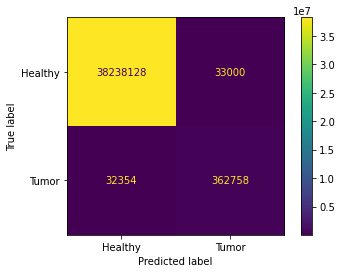

In [26]:
predlist = torch.zeros(0,dtype=torch.long, device='cpu')
lbllist = torch.zeros(0,dtype=torch.long, device='cpu')
predlistauc = torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        model.eval()
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        preds = torch.round(torch.sigmoid(outputs))

        # Append batch prediction results
        predlist = torch.cat([predlist,preds.view(-1).cpu()])
        lbllist = torch.cat([lbllist,classes.view(-1).cpu()])
        predlistauc = torch.cat([predlistauc,torch.sigmoid(outputs).view(-1).cpu()])
predlist = predlist.numpy()
lbllist = lbllist.numpy()
predlistauc = predlistauc.numpy()

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(lbllist, predlist).ravel()
target_names = ['Healthy','Tumor']   
ConfusionMatrixDisplay(np.concatenate((np.array([[tn, fp]]),np.array([[fn, tp]])),
                                      axis=0), display_labels=target_names).plot(values_format="d")                   
print(classification_report(lbllist, predlist, target_names=target_names))

### Next you can visualize scan/mask/prediction combinations to see results of model performance.

In [60]:
masks = torch.empty(1,1,image_size,image_size)
modeled_masks = torch.empty(1,1,image_size,image_size)
with torch.no_grad():
    for inputs, mask in val_loader:
        model.eval()       
        inputs= inputs.to(device)
        outputs = model(inputs)
        masks = torch.cat((masks,mask))
        modeled_masks = torch.cat((modeled_masks,outputs.cpu()))

In [61]:
normalize_transforms = transforms.Compose([
])

In [62]:
unnormalized_pics = torch.empty(1,3,image_size,image_size)
with torch.no_grad():
    for inputs, mask in val_loader:
        unnormalized_pics = torch.cat((unnormalized_pics, inputs))

In [94]:
count = 0
for j in range(100):
    count += 1
    fig = plt.figure(figsize=(20,8))

    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(unnormalized_pics[j+1].permute(1,2,0))
    ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax1.grid(False)

    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax2.imshow(masks[j+1].int().permute(1,2,0).squeeze(dim=2))
    ax2.grid(False)

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax3.imshow(torch.sigmoid(modeled_masks[j+1]).round().permute(1,2,0).squeeze(dim=2))
    ax3.grid(False)

    # plt.savefig('/content/drive/MyDrive/predictions/prediction_{}.png'.format(count), facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 200)
    plt.show()

### Also if we use our model as a classifier (look at how many tumors we predicted when there were none and backwards, etc.) we can calculate TP, TN, FP and FN, Recall, Precision and F1 score.

In [81]:
TP = 0
TN = 0
FP = 0
FN = 0
for i,mask in enumerate(masks[1:]):
    if mask.max() == 1:
        if torch.sigmoid(modeled_masks[i+1]).round().max() == 0:
            FN += 1
        if torch.sigmoid(modeled_masks[i+1]).round().max() == 1:  
            TP += 1      
    else:
        if torch.sigmoid(modeled_masks[i+1]).round().max() == 1:  
            FP += 1  
        if torch.sigmoid(modeled_masks[i+1]).round().max() == 0:
            TN += 1

In [94]:
print('''Segmentation as classification:
''')
print('TP:',TP)
print('TN:',TN)
print('FP:',FP)
print('FN:',FN)

Segmentation as classification:

TP: 202
TN: 369
FP: 7
FN: 12


In [87]:
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1 = 2*precision*recall/(precision+recall)
accuracy = (TP+TN)/(TP+TN+FP+FN)

In [91]:
print('''Segmentation as classification:
''')
print(f'Recall: {recall}')
print(f"Precision: {precision}")
print(f"F1 score: {f1}")
print(f'Accuracy: {accuracy}')

Segmentation as classification:

Recall: 0.9439252336448598
Precision: 0.9665071770334929
F1 score: 0.9550827423167848
Accuracy: 0.9677966101694915


### So this means that we predicted 94.4% out of all the scans with tumors (not necessarily each tumor in every scan) and 96.6% of scans we predicted to have tumor, had it.